In [1]:
from inference import run
from smartcam import smartcamLandmarker, smartcamDecoder, smartcamFramer, smartcamImager

/Users/arnaud/miniconda3/envs/hira/lib/python3.11/site-packages/pyqtgraph/colors/palette.py:1: RuntimeWarning: PyQtGraph supports Qt version >= 5.15, but 5.13.2 detected.
  from ..Qt import QtGui


In [2]:
import os
from basicsr.utils.download_util import load_file_from_url
from loguru import logger

from tqdm.notebook import tqdm
from realesrgan import RealESRGANer
from realesrgan.archs.srvgg_arch import SRVGGNetCompact

from inference import Reader, Writer

In [3]:
decoder = smartcamDecoder.SmartCamDecoder()
num_frames, total_time, video_rate = decoder.on_file("../code/inputs/S002-20250109/Rec-20250109-131827_lep2.zsc")
print(f"Number of frames: {num_frames}")
print(f"Total time: {total_time} seconds")
print(f"Video rate: {video_rate} fps")

Counting frames... ...16258 found  (file correctly closed)
Computing frame rate... ...video was recorded with average fps = 8.33
Number of frames: 16258
Total time: 1951.791051 seconds
Video rate: 8.329272742423287 fps


In [4]:
frame_index = 100

decoder.read_frame(frame_index)
vImg, vt, tImg, tt = decoder.get_images()
points_tuple = decoder.get_points()
vPts, vVis, tPts, tVis, score, lands = points_tuple

# Process the frame data as needed
print(f"Frame {frame_index}:")
print(f"Visible image shape: {vImg.shape if vImg is not None else 'None'}")
print(f"Thermal image shape: {tImg.shape if tImg is not None else 'None'}")
# print(f"Visible points: {vPts}")
# print(f"Thermal points: {tPts}")
print(f"Score: {score}")
# print(f"Landmarks: {lands}")
print("---")

Frame 100:
Visible image shape: (720, 540, 3)
Thermal image shape: (60, 80)
Score: 1
---


In [10]:
import numpy as np
from loguru import logger

class ReaderImg:
    def __init__(self, args, frame_array):
        self.args = args
        self.frame_array = frame_array
        self.current_frame_index = 0
        self.height, self.width, _ = frame_array.shape if frame_array else (0, 0, 0)
        self.input_fps = args.fps if args.fps is not None else 10
        self.audio = None  # Assuming no audio for frame array input
        # self.nb_frames = len(frame_array)

    def get_resolution(self):
        return self.height, self.width

    def get_fps(self):
        return self.input_fps

    def get_audio(self):
        return self.audio

    # def get_len(self):
    #     return self.nb_frames

    def __fps__(self):
        return self.input_fps

    def get_frame_from_stream(self):
        if self.current_frame_index >= self.nb_frames:
            return None
        img = self.frame_array[self.current_frame_index]
        self.current_frame_index += 1
        return img

    def close(self):
        # No need to close anything for frame array input
        pass

In [5]:
def inference_video(args, frame_array):#, video_save_path):
    # ---------------------- determine models according to model names ---------------------- #
    args.model_name = args.model_name.split('.pth')[0]
    if args.model_name == 'realesr-general-x4v3':  # x4 VGG-style model (S size)
        model = SRVGGNetCompact(num_in_ch=3, num_out_ch=3, num_feat=64, num_conv=32, upscale=4, act_type='prelu')
        netscale = 4
        file_url = [
            'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-wdn-x4v3.pth',
            'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-x4v3.pth'
        ]
    else:
        logger.error(f'Error: model name {args.model_name} is not supported.')

    # ---------------------- determine model paths ---------------------- #
    model_path = os.path.join('weights', args.model_name + '.pth')
    if not os.path.isfile(model_path):
        ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
        for url in file_url:
            # model_path will be updated
            model_path = load_file_from_url(
                url=url, model_dir=os.path.join(ROOT_DIR, 'weights'), progress=True, file_name=None)

    # use dni to control the denoise strength, base model only
    dni_weight = None
    if args.model_name == 'realesr-general-x4v3' and args.denoise_strength != 1:
        wdn_model_path = model_path.replace('realesr-general-x4v3', 'realesr-general-wdn-x4v3')
        model_path = [model_path, wdn_model_path]
        dni_weight = [args.denoise_strength, 1 - args.denoise_strength]

    # restorer
    upsampler = RealESRGANer(
        scale=netscale,
        model_path=model_path,
        dni_weight=dni_weight,
        model=model,
        # tile=args.tile, default 0
        # tile_pad=args.tile_pad,
        # pre_pad=args.pre_pad,
        half=args.fp16 # default to False
    )

    # reader = Reader(args, frame_array)
    # height, width = reader.get_resolution()
    # in_fps, in_len = reader.__fps__(), reader.get_len()
    # audio = reader.get_audio()
    # fps = reader.get_fps()
    # writer = Writer(args, audio, height, width, video_save_path, fps)
    height, width = frame_array.shape
    logger.info(f'Input video: {height}x{width}')#, fps: {in_fps}, frames: {in_len}, length: {in_len / in_fps:.2f}s')

    # pbar = tqdm(total=in_len, unit='frame', desc='inference')
    while True:
        # img = reader.get_frame_from_stream()
        if frame_array is None:
            break

        try:
            # try rescale
            frame_np = np.array(frame_array, dtype=np.float32)
            # frame_array_scaled = (frame_array - frame_np.max()) / (frame_np.max() - frame_np.min())
            frame_array_scaled_256 = ((frame_array - frame_np.max()) / (frame_np.max() - frame_np.min()) * 255).astype(np.uint8)
            output, _ = upsampler.enhance(frame_array_scaled_256, outscale=args.outscale)
            return output
        except RuntimeError as error:
            logger.error('Error', error)
            logger.error('If you encounter CUDA out of memory, try to set --tile with a smaller number.')
        # else:
        #     writer.write_frame(output)

        # torch.cuda.synchronize(device)
        # pbar.update(1)

    # reader.close()
    # writer.close()

In [6]:
from types import SimpleNamespace

args = SimpleNamespace()
args.model_name = 'realesr-general-x4v3'
args.denoise_strength = 0
args.outscale = 2
args.fp16 = False


In [68]:
outscaled = inference_video(args, tImg)

2025-02-18 09:37:15.395 | INFO     | __main__:inference_video:49 - Input video: 60x80


In [62]:
tImg.max(), tImg.min()#, outscaled.max(), outscaled.min()

(30779, 29205)

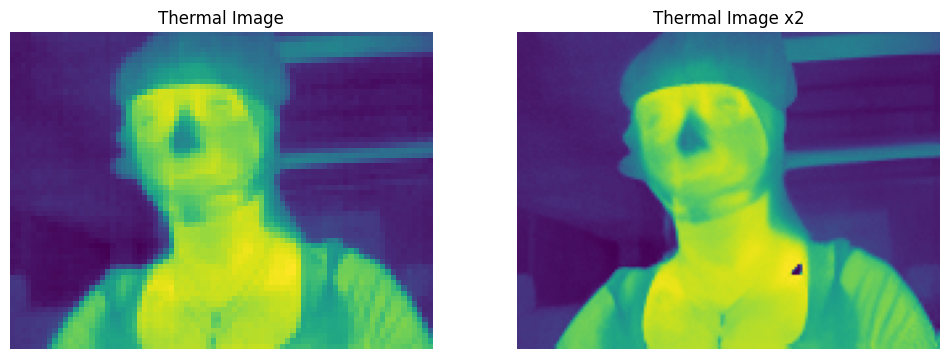

: 

In [69]:
import matplotlib.pyplot as plt

def visualize_upscaled_image(source, upscaled):

    # Visualize the images
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    if vImg is not None:
        axs[0].imshow(source)
        axs[0].set_title('Thermal Image')
        axs[0].axis('off')

    if tImg is not None:
        axs[1].imshow(upscaled)
        axs[1].set_title('Thermal Image x2')
        axs[1].axis('off')

    plt.show()

    # Close the file

# Example usage

visualize_upscaled_image(tImg, outscaled)

In [51]:
type(tImg), type(outscaled), (tImg.shape), (outscaled.shape)

(pims.frame.Frame, numpy.ndarray, (60, 80), (120, 160))

## All frames
At once ?


In [48]:
decoder = smartcamDecoder.SmartCamDecoder()
num_frames, total_time, video_rate = decoder.on_file("../code/inputs/S002-20250109/Rec-20250109-131827_lep2.zsc")
print(f"Number of frames: {num_frames}")
print(f"Total time: {total_time} seconds")
print(f"Video rate: {video_rate} fps")

Counting frames... ...16258 found  (file correctly closed)
Computing frame rate... ...video was recorded with average fps = 8.33
Number of frames: 16258
Total time: 1951.791051 seconds
Video rate: 8.329272742423287 fps


In [6]:
frame_index = 100

# decoder.read_frame(frame_index)
vImg, vt, tImg, tt = decoder.get_images()
points_tuple = decoder.get_points()
vPts, vVis, tPts, tVis, score, lands = points_tuple

# Process the frame data as needed
print(f"Frame {frame_index}:")
print(f"Visible image shape: {vImg.shape if vImg is not None else 'None'}")
print(f"Thermal image shape: {tImg.shape if tImg is not None else 'None'}")
# print(f"Visible points: {vPts}")
# print(f"Thermal points: {tPts}")
print(f"Score: {score}")
# print(f"Landmarks: {lands}")
print("---")

Frame 100:
Visible image shape: (720, 540, 3)
Thermal image shape: (60, 80)
Score: 1
---


In [12]:
tImg.min()

29203

In [7]:
import  numpy as np

decoder = smartcamDecoder.SmartCamDecoder()
num_frames, total_time, video_rate = decoder.on_file("../code/inputs/S002-20250109/Rec-20250109-131827_lep2.zsc")
print(f"Number of frames: {num_frames}")
print(f"Total time: {total_time} seconds")
print(f"Video rate: {video_rate} fps")

decoder.read_frame(0)
vImg, vt, tImg, tt = decoder.get_images()
height, width = tImg.shape
frames_np = np.empty((num_frames, height, width), dtype=np.uint16)  # Preallocate

for i in range(num_frames):
    # convert
    decoder.read_frame(i)
    vImg, vt, tImg, tt = decoder.get_images()
    frame_np = np.array(tImg, dtype=np.float32)
    frame_array_scaled_256 = ((tImg - frame_np.max()) / (frame_np.max() - frame_np.min()) * 255).astype(np.uint8)
    frames_np[i] = frame_array_scaled_256  # Assign directly

print(frames_np.shape)  # (100, height, width)


Counting frames... ...16258 found  (file correctly closed)
Computing frame rate... ...video was recorded with average fps = 8.33
Number of frames: 16258
Total time: 1951.791051 seconds
Video rate: 8.329272742423287 fps
(16258, 60, 80)


In [11]:
import ffmpeg

In [12]:
def inference_video(args, frame_array, video_save_path, fps):
    # ---------------------- determine models according to model names ---------------------- #
    args.model_name = args.model_name.split('.pth')[0]
    if args.model_name == 'realesr-general-x4v3':  # x4 VGG-style model (S size)
        model = SRVGGNetCompact(num_in_ch=3, num_out_ch=3, num_feat=64, num_conv=32, upscale=4, act_type='prelu')
        netscale = 4
        file_url = [
            'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-wdn-x4v3.pth',
            'https://github.com/xinntao/Real-ESRGAN/releases/download/v0.2.5.0/realesr-general-x4v3.pth'
        ]
    else:
        logger.error(f'Error: model name {args.model_name} is not supported.')

    # ---------------------- determine model paths ---------------------- #
    model_path = os.path.join('weights', args.model_name + '.pth')
    if not os.path.isfile(model_path):
        ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
        for url in file_url:
            # model_path will be updated
            model_path = load_file_from_url(
                url=url, model_dir=os.path.join(ROOT_DIR, 'weights'), progress=True, file_name=None)

    # use dni to control the denoise strength, base model only
    dni_weight = None
    if args.model_name == 'realesr-general-x4v3' and args.denoise_strength != 1:
        wdn_model_path = model_path.replace('realesr-general-x4v3', 'realesr-general-wdn-x4v3')
        model_path = [model_path, wdn_model_path]
        dni_weight = [args.denoise_strength, 1 - args.denoise_strength]

    # restorer
    upsampler = RealESRGANer(
        scale=netscale,
        model_path=model_path,
        dni_weight=dni_weight,
        model=model,
        # tile=args.tile, default 0
        # tile_pad=args.tile_pad,
        # pre_pad=args.pre_pad,
        half=args.fp16 # default to False
    )

    # reader = Reader(args, frame_array)
    # height, width = reader.get_resolution()
    # in_fps, in_len = reader.__fps__(), reader.get_len()
    # audio = reader.get_audio()
    # fps = reader.get_fps()
    if len(frame_array.shape) == 2 : height, width = frame_array.shape
    elif len(frame_array.shape) == 3 : height, width = frame_array[0].shape
    # writer = Writer(args, None, height, width, video_save_path, fps)
    process = (ffmpeg.input('pipe:', format='rawvideo', pix_fmt='gray', s=f'{width}x{height}', framerate=fps)
            .output(video_save_path, vcodec='libx264', pix_fmt='yuv420p', loglevel="error")
            .overwrite_output()
            .run_async(pipe_stdin=True))
    logger.info(f'Input video: {height}x{width}')#, fps: {in_fps}, frames: {in_len}, length: {in_len / in_fps:.2f}s')

    pbar = tqdm(total=frame_array.shape[0], unit='frame', desc='inference')
    i = 0
    up_frames_np = np.empty((frame_array.shape[0], height*args.outscale, width*args.outscale), dtype=np.uint16) 
    while i < frame_array.shape[0]:
        frame = frame_array[i]
        if frame is None:
            break

        try:
            # try rescale
            frame_np = np.array(frame, dtype=np.float32)
            # frame_scaled = (frame - frame_np.max()) / (frame_np.max() - frame_np.min())
            frame_scaled_256 = ((frame - frame_np.max()) / (frame_np.max() - frame_np.min()) * 255).astype(np.uint8)
            # print(frame_scaled_256.shape)
            output, _ = upsampler.enhance(frame_scaled_256, outscale=args.outscale)
            # return output
        except RuntimeError as error:
            logger.error('Error', error)
            logger.error('If you encounter CUDA out of memory, try to set --tile with a smaller number.')
        else:
            # writer.write_frame(output)
            frame = np.full((height, width), i % 256, dtype=np.uint8)
            process.stdin.write(output.tobytes())

            up_frames_np[i] = output

        # torch.cuda.synchronize(device)
        i += 1
        pbar.update(1)
    # reader.close()
    # writer.close()
    process.stdin.close()
    process.wait()
    return up_frames_np

In [13]:
from types import SimpleNamespace

args = SimpleNamespace()
args.model_name = 'realesr-general-x4v3'
args.denoise_strength = 0
args.outscale = 2
args.fp16 = False
args.ffmpeg_bin = 'ffmpeg'

In [70]:
np.array([frames_np[0]]).shape

(1, 60, 80)

In [14]:
out = inference_video(args, frames_np[0:200], "output.mp4", 8)

2025-02-18 11:40:16.635 | INFO     | __main__:inference_video:54 - Input video: 60x80


inference:   0%|          | 0/200 [00:00<?, ?frame/s]

In [92]:
out.shape

(20, 120, 160)

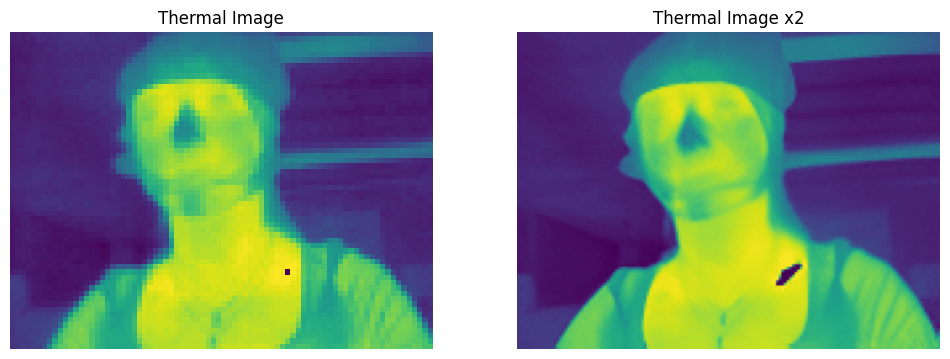

In [ ]:
import matplotlib.pyplot as plt
def visualize_upscaled_image(source, upscaled):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(source)
    axs[0].set_title('Thermal Image')
    axs[0].axis('off')

    axs[1].imshow(upscaled)
    axs[1].set_title('Thermal Image x2')
    axs[1].axis('off')

    plt.show()

visualize_upscaled_image(frames_np[0], out[50])

## Visualization attempts


In [40]:
%matplotlib qt 

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def dynamic_plot(images, interval=0.001):
    plt.ion()  
    fig, ax = plt.subplots()
    
    img_display = ax.imshow(images[0], cmap='gray', vmin=0, vmax=255)
    
    for img in images:
        img_display.set_data(img)
        plt.pause(interval)

    plt.ioff()
    plt.show()

# Example usage
dynamic_plot(frames_np)


In [33]:
import cv2
import numpy as np

A = list(frames_np)
framesize = (80, 60)

out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'H264'), 8.0, framesize, isColor=False)

for img in A:
    out.write(img.astype('uint8'))

out.release()

print("MP4 video saved as output_video.mp4")


MP4 video saved as output_video.mp4


OpenCV: FFMPEG: tag 0x34363248/'H264' is not supported with codec id 27 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x31637661/'avc1'


In [ ]:
import matplotlib.pyplot as plt

def visualize_upscaled_images(file_path):
    # Initialize the decoder
    decoder = smartcam.SmartCamDecoder()

    # Open the file
    num_frames, total_time, video_rate = decoder.on_file(file_path)
    print(f"Number of frames: {num_frames}")
    print(f"Total time: {total_time} seconds")
    print(f"Video rate: {video_rate} fps")

    # Read and process each frame
    for frame_index in range(num_frames):
        decoder.read_frame(frame_index)
        vImg, vt, tImg, tt = decoder.get_images()
        points_tuple = decoder.get_points()
        vPts, vVis, tPts, tVis, score, lands = points_tuple

        # Process the frame data as needed
        print(f"Frame {frame_index}:")
        print(f"Visible image shape: {vImg.shape if vImg is not None else 'None'}")
        print(f"Thermal image shape: {tImg.shape if tImg is not None else 'None'}")
        print(f"Visible points: {vPts}")
        print(f"Thermal points: {tPts}")
        print(f"Score: {score}")
        print(f"Landmarks: {lands}")
        print("---")

        # Visualize the images
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        if vImg is not None:
            axs[0].imshow(vImg)
            axs[0].set_title('Visible Image')
            axs[0].axis('off')

        if tImg is not None:
            axs[1].imshow(tImg, cmap='gray')
            axs[1].set_title('Thermal Image')
            axs[1].axis('off')

        plt.show()

    # Close the file
    decoder.on_file(None)

# Example usage
file_path = '/path/to/your/smartcam_file.zsc'
visualize_upscaled_images(file_path)

qt.core.qobject.connect: QObject::connect(QStyleHints, QStyleHints): unique connections require a pointer to member function of a QObject subclass


AttributeError: 'ImageItem' object has no attribute 'geometryChanged'